# Predicting the popularity of news on Facebook, Google+, and LinkedIn
# For this project, we start with the sample data 
# The data model is built in the following steps 
# 1. Use information gain to evaluate the siginificance of the given features to the targets.
# 2. Use Latent semantic analysis to improve data quality. Because, text mining depends on the context. We need to define the context for the given news.
# 3. Use KNN to get rid of outliers.
# 4. After sample selection, we check information gain, again and it goes up.
# 5. We choose Source, SentimentTitle, SentimentHeadline as features and use KNN to build a classification model to predict news popularity on Facebook, GooglePlus and LinkedIn.
# 6. We compared both the poularity scores and the text between the given news and the similar news.
# 6.1 For popularity scores: predicted (Facebook:5, GooglePlus:0, LinkedIn:5), Actual (Facebook:6, GooglePlus:0, LinkedIn:0)
# 6.2 For the content of the similar news, they are about the same thing.


In [ ]:
### Download data
Source: http://archive.ics.uci.edu/ml/datasets/News+Popularity+in+Multiple+Social+Media+Platforms

%%bash

wget -nc -O news-final.csv http://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/News_Final.csv; 
wget -nc -O facebook-microsoft.csv http://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/Facebook_Microsoft.csv;
wget -nc -O googleplus-microsoft.csv http://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/GooglePlus_Microsoft.csv;
wget -nc -O linkedin-microsoft.csv http://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/LinkedIn_Microsoft.csv &


In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt


### Load data and set index

In [2]:
news = pd.read_csv('news-final.csv')
news = news[news['Topic']=='microsoft']
news = news.drop('Topic', 1)

news['IDLink'] = news['IDLink'].astype(int)
news = news.set_index('IDLink')


facebook = pd.read_csv('facebook-microsoft.csv')
facebook = facebook.set_index('IDLink')

google = pd.read_csv('googleplus-microsoft.csv')
google = google.set_index('IDLink')

linkedin = pd.read_csv('linkedin-microsoft.csv')
linkedin = linkedin.set_index('IDLink')


### Restrict to articles appearing on all 3 sites

In [3]:
posted_everywhere = news[['Facebook', 'GooglePlus', 'LinkedIn']].min(axis=1) > -1

news = news[posted_everywhere]

In [4]:
news.head()

,Title,Headline,Source,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
IDLink,,,,,,,,,
311,Microsoft offering £100 discount on original B...,Just ahead of the market rollout of Microsoft'...,International Business Times via Yahoo UK & Ir...,2015-11-08 05:25:00,0.000000,-0.132812,0,0,0
307,Microsoft scales back free online storage plans,NEW YORK — Microsoft is getting stingy with on...,The Columbian,2015-11-08 06:54:00,0.106303,-0.207333,0,0,0
299,Microsoft’s OneDrive debacle shows its cloud c...,When Microsoft announced earlier this week tha...,Digital Trends via Yahoo! News,2015-11-08 12:15:00,-0.166139,-0.259052,6,0,1
328,Microsoft to play a big part in Digital India,"Bhaskar Pramanik, Chairman, Microsoft India, s...",DNA India,2015-11-08 16:47:00,-0.018326,0.062500,11,1,1
587,Microsoft risks IT ire with Windows 10 update ...,Microsoft has made it clear that it will take...,MIS Asia,2015-11-08 18:54:00,-0.165728,0.146390,89,0,0


### Restrict to sources with at least 50 articles

In [5]:
greater_than_50 = (news['Source'].value_counts() > 50)

sources_50 = greater_than_50[greater_than_50 > 0].index

print("Number of sources with at least 50 articles: {}".format(greater_than_50.sum()))

news = news[news['Source'].isin(sources_50)]


Number of sources with at least 50 articles: 75


### Process dates

In [6]:
news.loc[:, 'PublishDate'] = pd.to_datetime(news['PublishDate'])

news.loc[:, 'Year'] = news['PublishDate'].dt.year
news.loc[:, 'Month'] = news['PublishDate'].dt.month
news.loc[:, 'DayOfWeek'] = news['PublishDate'].dt.weekday
news.loc[:, 'Hour'] = news['PublishDate'].dt.hour

In [7]:
import datetime

In [8]:
news['PublishDate'].max()

may_1_2016 = datetime.datetime(2016, 5, 1)

news_historical = news[news['PublishDate'] <= may_1_2016]
news_new = news[news['PublishDate'] > may_1_2016]

## ML

In [9]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import base

In [10]:
df = news_historical.drop(['PublishDate'], 1)

In [11]:
df_new = news_new.drop(['PublishDate'], 1)
df_new.head()

,Title,Headline,Source,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,Year,Month,DayOfWeek,Hour
IDLink,,,,,,,,,,,,
46462,Get a $50 Microsoft Store gift card with Xbox ...,The $50 discount for the Xbox One is no longer...,Windows Central,-0.096466,-0.029167,9,2,1,2016,5,6,8
46791,Flow is Microsoft’s answer to IFTTT,IFTTT (If This Then That) is looking at big co...,Digital Trends via Yahoo! News,0.010499,0.089970,0,0,0,2016,5,6,11
46538,Microsoft's IE loses top browser spot to Googl...,Internet Explorer in April lost the No. 1 spot...,Computer World Australia,-0.092593,-0.038044,111,0,6,2016,5,6,11
46542,This Microsoft legend says the the company is ...,Microsoft Research is more important to the te...,Business Insider via Yahoo! Finance,0.000000,0.000000,1,0,0,2016,5,6,11
46569,Windows 10 Mobile Build 10586.306 now being te...,Microsoft is actively working on the next majo...,MSPoweruser.com,0.094491,0.167705,23,0,0,2016,5,6,14


In [12]:

#import modules for news selection
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from gensim import models

In [13]:

from nltk.corpus import stopwords


def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    doc_clean = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        doc_clean.append(stemmed_tokens)

    
    return doc_clean


def prepare_corpus(doc_clean):
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    dicitonary = dictionary
    doc_term_matrix = doc_term_matrix
    corpus = [dictionary.doc2bow(text) for text in doc_clean]
    
    return dictionary,doc_term_matrix

def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    #print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel


def compute_coherence_values(dictionary, doc_term_matrix, doc_clean,number_of_topics, stop, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    model_list = model_list
    coherence_values = coherence_values
    return model_list, coherence_values

def buildModel(doc_clean, number_of_topics,stop, start, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,number_of_topics, stop, start, step)
    return model_list, coherence_values

def similarity(doc, corpus, dictionary, numTopics):
    lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=numTopics)
    vec_bow = self.dictionary.doc2bow(doc.lower().split())
    vec_lsi = lsi[vec_bow]  # convert the query to LSI space
    #print(vec_lsi)
    return vec_lsi


In [14]:
from scipy.stats import entropy
import pandas as pd
def information_gain(members, split):
    
    entropy_before = entropy(members.value_counts(normalize=True))
    split.name = 'split'
    members.name = 'members'
    grouped_distrib = members.groupby(split) \
                        .value_counts(normalize=True) \
                        .reset_index(name='count') \
                        .pivot_table(index='split', columns='members', values='count').fillna(0) 
    entropy_after = entropy(grouped_distrib, axis=1)
    entropy_after *= split.value_counts(sort=False, normalize=True)
    return (entropy_before - entropy_after.sum())/entropy_before



# Feature Selection

# According to Information Gain, SentimentTitle and SentimentHeadline are not considered as good features to predict popularity on Facebook, GooglePlus, and LinkedIn.

In [15]:
info_title_fb =information_gain(df['SentimentTitle'],df['Facebook'])
info_headline_fb =information_gain(df['SentimentHeadline'],df['Facebook'])
info_source_fb =information_gain(df['Source'],df['Facebook'])
print(info_title_fb, info_headline_fb,info_source_fb)

0.6427983828436333 0.682137527933072 0.6065400706568865


In [16]:
info_title_google=information_gain(df['SentimentTitle'],df['GooglePlus'])
info_headline_google=information_gain(df['SentimentHeadline'],df['GooglePlus'])
info_source_google=information_gain(df['Source'],df['GooglePlus'])
print(info_title_google, info_headline_google,info_source_google)

0.4545358118900283 0.48596147409162366 0.4117329019171993


In [17]:
info_title_linkedin=information_gain(df['SentimentTitle'],df['LinkedIn'])
info_headline_linkedin=information_gain(df['SentimentHeadline'],df['LinkedIn'])
info_source_linkedin=information_gain(df['Source'],df['LinkedIn'])
print(info_title_linkedin, info_headline_linkedin,info_source_linkedin)

0.5177361250103715 0.5575869048549802 0.4672467847269911


# For Title and Headline, we use Latent semantic analysis to find similar news as a subset

In [18]:

doc_clean = preprocess_data(df['Title'])
dictionary, doc_term_matrix = prepare_corpus(doc_clean)

#start,repeats,step=1,20,1
#number_of_topics = 20
#model_list, coherence_values = buildModel(doc_clean, number_of_topics,repeats, start, step)
#df_coh = pd.DataFrame(coherence_values, columns=['coherence_values'])

#max_coherence = df_coh[df_coh['coherence_values']==df_coh['coherence_values'].max()]
#numTopic = max_coherence.index.values[0]
#model_title = model_list[numTopic]
#print("num topics" + str(len(model_list)))
#model_title.save('model_title.lsi')


model_title = models.LsiModel.load('model_title.lsi')


TitleTopics = []
for i in range(len(doc_clean)):
    doc = doc_clean[i]
    vec_bow = dictionary.doc2bow(doc) 
    vec_lsi = model_title[vec_bow]   # convert the query to LSI space
    df_vec_lsi = pd.DataFrame(vec_lsi)
    m = df_vec_lsi[df_vec_lsi[1] == df_vec_lsi[1].max()].index.values
    TitleTopics.append(m[0])


In [19]:
#find similar articles
#news_new_test = news_new[0:1]
df_test = news_new[15:16]

df_topic = df_test.copy()

df_test

,Title,Headline,Source,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,Year,Month,DayOfWeek,Hour
IDLink,,,,,,,,,,,,,
46599,Xbox One Backward Compatibility: Two new games...,They weren't the only classic announced by Mic...,Express.co.uk,2016-05-01 23:40:23,0.169094,-0.050339,6,0,0,2016,5,6,23


In [20]:

df_topic 

doc = df_topic['Title'].values[0]


corpus = [dictionary.doc2bow(text) for text in doc_clean]

vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = model_title[vec_bow]  # convert the query to LSI space
print(vec_lsi)


[(0, 0.1805556249963556), (1, -0.049669842824401816), (2, 0.30886303932878834), (3, -1.205288752979753)]


In [25]:
from gensim import similarities

index = similarities.MatrixSimilarity(model_headline[corpus])  # transform corpus to LSI space and index it
sims = index[vec_lsi]  # perform a similarity query against the corpus
df_sims = pd.DataFrame(list(enumerate(sims)), columns=['Index','similarity'])  # print (document_number, document_similarity) 2-tuples


In [26]:
#Set Similarity to 90%
#check information gain to decide if feature sets are valuable to Popularity in Facebook, GooglePlus and LinkedIn
df_copy_headline = df_headline.copy(deep=True)
df_copy_headline = df_copy_headline.reset_index()

df_copy_headline['similarity'] = df_sims['similarity']

df_sims_sorted = df_copy_headline.sort_values(by=['similarity'],ascending=False)
df_sims_sorted_large = df_sims_sorted[df_sims_sorted['similarity']>0.70]
df_sims_sorted_large[df_sims_sorted_large['Source']=='Express.co.uk']

,index,IDLink,Title,Headline,Source,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,Year,Month,DayOfWeek,Hour,similarity
96,4578,25499,Xbox One update: Microsoft reveal new features...,Gamers will now find it easier to get details ...,Express.co.uk,0.001647,-0.036089,4,5,1,2016,2,3,17,0.925622
113,7347,43111,Xbox One Backward Compatibility: Microsoft's S...,Microsoft started the month off by making the ...,Express.co.uk,0.125217,-0.094238,6,0,0,2016,4,0,0,0.897017
80,7573,44103,Xbox One Backward Compatibility: Microsoft rel...,"This week in comparison has been very quiet, M...",Express.co.uk,0.156521,0.061450,5,0,0,2016,4,3,20,0.795583
110,4386,24563,Xbox One Backward Compatibility: Microsoft con...,Microsoft recently bulked up the list of game ...,Express.co.uk,0.125217,0.079167,7,2,0,2016,2,0,5,0.722096
38,4325,23920,Xbox One Backward Compatibility: Four games la...,Microsoft has yet to confirm that RDR will be ...,Express.co.uk,0.000000,-0.007995,13,0,0,2016,2,3,18,0.700693


In [27]:
info_title_facebook=information_gain(df_sims_sorted_large['SentimentTitle'],df_sims_sorted_large['Facebook'])
info_headline_facebook=information_gain(df_sims_sorted_large['SentimentHeadline'],df_sims_sorted_large['Facebook'])
info_source_facebook=information_gain(df_sims_sorted_large['Source'],df_sims_sorted_large['Facebook'])
print(info_title_facebook, info_headline_facebook,info_source_facebook)

0.7061786710901997 0.7293903953560184 0.7423477017683362


<AxesSubplot:xlabel='SentimentTitle', ylabel='Facebook'>

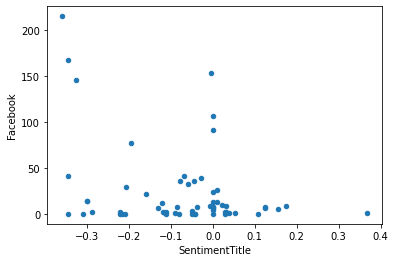

In [28]:
df_sims_sorted_large.plot.scatter(x='SentimentTitle', y='Facebook')

<AxesSubplot:xlabel='SentimentHeadline', ylabel='Facebook'>

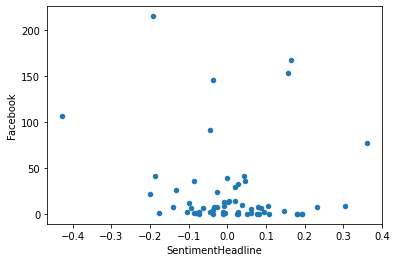

In [29]:
df_sims_sorted_large.plot.scatter(x='SentimentHeadline', y='Facebook')

In [30]:
info_title_google=information_gain(df_sims_sorted_large['SentimentTitle'],df_sims_sorted_large['GooglePlus'])
info_headline_google=information_gain(df_sims_sorted_large['SentimentHeadline'],df_sims_sorted_large['GooglePlus'])
info_source_google=information_gain(df_sims_sorted_large['Source'],df_sims_sorted_large['GooglePlus'])
print(info_title_google, info_headline_google,info_source_google)

0.353418789619028 0.36744488682143817 0.336005846590412


<AxesSubplot:xlabel='SentimentTitle', ylabel='GooglePlus'>

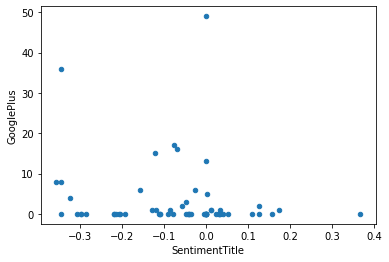

In [31]:
df_sims_sorted_large.plot.scatter(x='SentimentTitle', y='GooglePlus')

<AxesSubplot:xlabel='SentimentHeadline', ylabel='GooglePlus'>

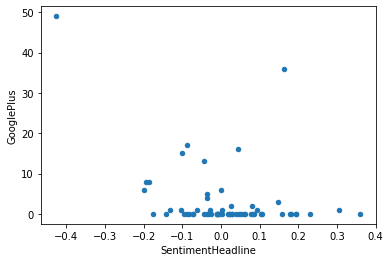

In [32]:
df_sims_sorted_large.plot.scatter(x='SentimentHeadline', y='GooglePlus')

In [33]:
info_title_linkedin=information_gain(df_sims_sorted_large['SentimentTitle'],df_sims_sorted_large['LinkedIn'])
info_headline_linkedin=information_gain(df_sims_sorted_large['SentimentHeadline'],df_sims_sorted_large['LinkedIn'])
info_source_linkedin=information_gain(df_sims_sorted_large['Source'],df_sims_sorted_large['LinkedIn'])
print(info_title_linkedin, info_headline_linkedin,info_source_linkedin)

0.4946037096556242 0.515987333976472 0.48191763724577164


<AxesSubplot:xlabel='SentimentTitle', ylabel='LinkedIn'>

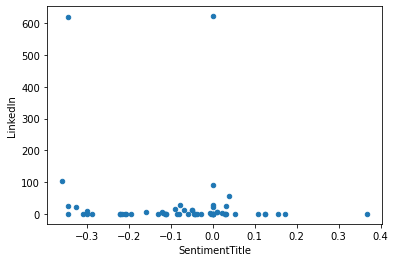

In [34]:
df_sims_sorted_large.plot.scatter(x='SentimentTitle', y='LinkedIn')

<AxesSubplot:xlabel='SentimentHeadline', ylabel='LinkedIn'>

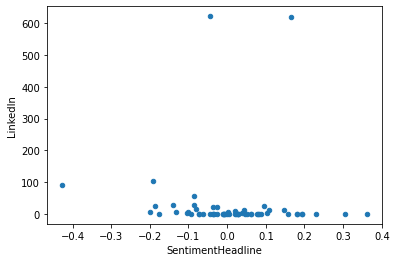

In [35]:
df_sims_sorted_large.plot.scatter(x='SentimentHeadline', y='LinkedIn')

# KNN Classification

# Find the nearest neighbors of the given news
# predict popularity with the number of views of its neighbors

In [36]:

df_sims_sorted_large.head(2)

,index,IDLink,Title,Headline,Source,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,Year,Month,DayOfWeek,Hour,similarity
90,6453,38528,Skype is getting infused with conversational “...,Microsoft is hoping to make Skype conversatio...,PC World,0.000000,-0.140900,7,0,28,2016,3,2,11,0.989598
56,2385,13862,"Xbox enjoys record-breaking Christmas, Rise of...",All of Microsoft's holiday 2015 exclusives sol...,CNET,-0.003814,0.158114,153,0,1,2016,1,0,11,0.989137


In [37]:
news_new.head(1)

,Title,Headline,Source,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,Year,Month,DayOfWeek,Hour
IDLink,,,,,,,,,,,,,
46462,Get a $50 Microsoft Store gift card with Xbox ...,The $50 discount for the Xbox One is no longer...,Windows Central,2016-05-01 08:47:22,-0.096466,-0.029167,9,2,1,2016,5,6,8


In [38]:
from sklearn.neighbors import NearestNeighbors

In [39]:

df_test = df_topic.copy()

In [40]:
S1 = pd.DataFrame(df_sims_sorted_large['Source'])
S1_rename = S1.reset_index()

S1_rename = S1_rename.rename(columns={'members':'Source'})
S1_count = S1_rename.groupby('Source')['Source'].count()
S1_count = S1_count.to_frame()
S1_count = S1_count.rename(columns={'Source':'Count'})
S1_count = S1_count.reset_index()

df_test = df_topic.copy()
df_test
df_test = pd.merge(df_test, S1_count, on='Source', how='left')
index = list(range(len(S1_count)))
index
S1_count['Category'] = index
S1_count = pd.merge(S1_rename, S1_count, on='Source', how='left')
max = S1_count['Count'].max()
S1_count['CountNorm'] = S1_count['Count']/max
df_test['CountNorm'] = df_test['Count']/max


# 1. Facebook. Use KNN to predict the popularity of a given news on Facebook.
#    Facebook prediction: 5, Compare to actual value: 6

In [41]:
FB = pd.DataFrame(df_sims_sorted_large['Facebook'])
FB = FB.rename(columns={'split':'Facebook'})
max = FB['Facebook'].max()
FB['FacebookNorm'] = FB['Facebook'].apply(lambda s: s/max)
df_test['FacebookNorm'] = df_test['Facebook'].apply(lambda s: s/max)
FB_rename = FB.reset_index()
FB_rename.head(5)

,index,Facebook,FacebookNorm
0,90,7,0.032558
1,56,153,0.711628
2,20,77,0.358140
3,101,146,0.679070
4,9,1,0.004651


In [42]:
S1 = pd.DataFrame(list(S1_count['CountNorm']))
S1.to_numpy()
S2 = pd.DataFrame(list(df_sims_sorted_large['SentimentTitle']))
S2.to_numpy()
S3 = pd.DataFrame(list(df_sims_sorted_large['SentimentHeadline']))
S3.to_numpy()
S4 = pd.DataFrame(list(FB_rename['FacebookNorm']))
XX= np.append(S1,S2,axis=1)
XX = np.append(XX,S3,axis=1)
XX = np.append(XX,S4,axis=1)
nbrs_fb = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(XX)
distances, indices = nbrs_fb.kneighbors(XX)
knn = pd.DataFrame(indices)
knn = knn.rename(columns={1:'NeighborID',0:'NodeID'})
knn['distance'] = pd.DataFrame(distances)[1]
knn['index'] = list(df_sims_sorted_large['index'])
knn['Facebook']=list(FB_rename['Facebook'])
knn['FacebookNorm']=list(FB_rename['FacebookNorm'])
knn['CountNorm']=list(S1_count['CountNorm'])

<AxesSubplot:xlabel='NodeID', ylabel='distance'>

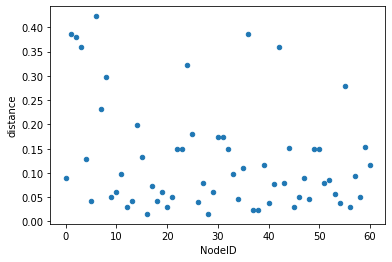

In [43]:
knn.plot.scatter(x='NodeID', y='distance')

<AxesSubplot:xlabel='distance', ylabel='Facebook'>

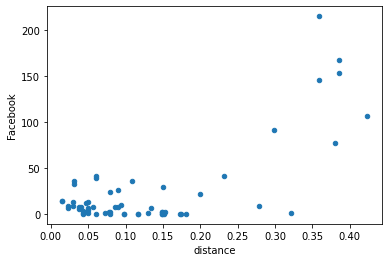

In [44]:
knn.plot.scatter(x='distance', y='Facebook')

In [45]:
knn_small_range = knn.copy()
knn_small_range = pd.merge(knn_small_range, df_sims_sorted_large, on=['index','Facebook'])
knn_small_range['range'] = knn_small_range['distance'].apply(lambda s: round(s, 1))
knn_small_group = knn_small_range.groupby('range')['range'].count()

knn_small_group

range
0.0    18
0.1    26
0.2     8
0.3     3
0.4     6
Name: range, dtype: int64

In [46]:
knn_small_result= knn_small_range[knn_small_range['range'] < 0.2]
df_knn_small = knn_small_result.copy()
df_knn_small.shape

(44, 21)

In [47]:

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split 



S1 = pd.DataFrame(list(df_knn_small['CountNorm']))

S2 = pd.DataFrame(list(df_knn_small['SentimentTitle']))

S3 = pd.DataFrame(list(df_knn_small['SentimentHeadline']))

S4 = df_knn_small['Facebook']


X= np.append(S1,S2,axis=1)
X = np.append(X,S3,axis=1)
y = S4.values


knn = KNeighborsClassifier(n_neighbors=2) 


knn.fit(X, y) 

S1 = pd.DataFrame(list(df_test['CountNorm']))
S2 = pd.DataFrame(list(df_test['SentimentTitle']))
S3 = pd.DataFrame(list(df_test['SentimentHeadline']))
S4 = df_test['Facebook']


X_test= np.append(S1,S2,axis=1)
X_test = np.append(X_test,S3,axis=1)
y_test = S4

# Calculate the accuracy of the model 
#print(knn.score(X_train, y_train)) 

print("Predicted as :", knn.predict(X_test)[0], ", Actual Score :", y_test.values[0]) 

Predicted as : 5 , Actual Score : 6


In [48]:
print(knn.kneighbors(X_test))

(array([[0.06206687, 0.11249376]]), array([[ 8, 27]]))


In [49]:
knn_visual_facebook = df_knn_small[2:3]
knn_visual_facebook = knn_visual_facebook.append(df_knn_small[20:21])

# 2. Google Plus: use KNN to predict Popularity
# GooglePlus prediction: 0, Compare to actual value: 0

In [50]:
GP = pd.DataFrame(df_sims_sorted_large['GooglePlus'])
GP = GP.rename(columns={'split':'GooglePlus'})
max = GP['GooglePlus'].max()
GP['GooglePlusNorm'] = GP['GooglePlus'].apply(lambda s: s/max)
GP_rename = GP.reset_index()
df_test['GooglePlusNorm'] = df_test['GooglePlus'].apply(lambda s: s/max)

In [51]:
S1 = pd.DataFrame(list(S1_count['CountNorm']))
S1.to_numpy()
S2 = pd.DataFrame(list(df_sims_sorted_large['SentimentTitle']))
S2.to_numpy()
S3 = pd.DataFrame(list(df_sims_sorted_large['SentimentHeadline']))
S3.to_numpy()
S4 = pd.DataFrame(list(GP_rename['GooglePlusNorm']))
XX= np.append(S1,S2,axis=1)
XX = np.append(XX,S3,axis=1)
XX = np.append(XX,S4,axis=1)
nbrs_gp = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(XX)
distances, indices = nbrs_gp.kneighbors(XX)
knn = pd.DataFrame(indices)
knn = knn.rename(columns={1:'NeighborID',0:'NodeID'})
knn['distance'] = pd.DataFrame(distances)[1]
knn['index'] = list(df_sims_sorted_large['index'])
knn['GooglePlus']=list(GP_rename['GooglePlus'])
knn['GooglePlusNorm']=list(GP_rename['GooglePlusNorm'])
knn['CountNorm']=list(S1_count['CountNorm'])

<AxesSubplot:xlabel='NodeID', ylabel='distance'>

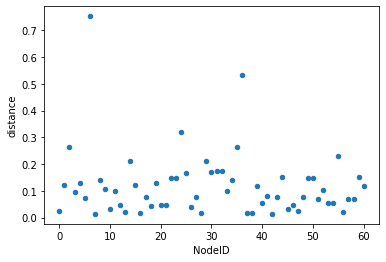

In [52]:
knn.plot.scatter(x='NodeID', y='distance')

<AxesSubplot:xlabel='distance', ylabel='GooglePlus'>

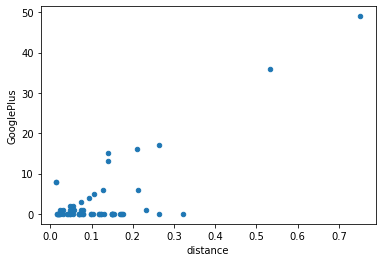

In [53]:
knn.plot.scatter(x='distance', y='GooglePlus')

In [54]:
knn_small_range = knn.copy()
knn_small_range = pd.merge(knn_small_range, df_sims_sorted_large, on=['index','GooglePlus'])
knn_small_range['range'] = knn_small_range['distance'].apply(lambda s: round(s, 1))
knn_small_group = knn_small_range.groupby('range')['range'].count()

knn_small_group

range
0.0    18
0.1    29
0.2     9
0.3     3
0.5     1
0.8     1
Name: range, dtype: int64

In [55]:
knn_small_result = knn_small_range[knn_small_range['range']<0.2]
df_knn_small = knn_small_result.copy()
df_knn_small.shape

(47, 21)

In [56]:

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split 



S1 = pd.DataFrame(list(df_knn_small['CountNorm']))

S2 = pd.DataFrame(list(df_knn_small['SentimentTitle']))

S3 = pd.DataFrame(list(df_knn_small['SentimentHeadline']))

S4 = df_knn_small['GooglePlus']


X= np.append(S1,S2,axis=1)
X = np.append(X,S3,axis=1)
y = S4.values


knn = KNeighborsClassifier(n_neighbors=2) 


knn.fit(X, y) 

S1 = pd.DataFrame(list(df_test['CountNorm']))
S2 = pd.DataFrame(list(df_test['SentimentTitle']))
S3 = pd.DataFrame(list(df_test['SentimentHeadline']))
S4 = df_test['GooglePlus']


X_test= np.append(S1,S2,axis=1)
X_test = np.append(X_test,S3,axis=1)
y_test = S4

# Calculate the accuracy of the model 
#print(knn.score(X_train, y_train)) 

print("Predicted as :", knn.predict(X_test)[0], ", Actual Score :", y_test.values[0]) 

Predicted as : 0 , Actual Score : 0


In [57]:
print(knn.kneighbors(X_test))

(array([[0.06206687, 0.11249376]]), array([[12, 29]]))


In [58]:
knn_visual_google = df_knn_small[11:12]
knn_visual_google = knn_visual_google.append(df_knn_small[33:34])

# 3. LinkedIn. Use KNN to predict Popularity
#    LinkedIn prediction: 5, Compare to actual value: 6

In [59]:
LI = pd.DataFrame(df_sims_sorted_large['LinkedIn'])
LI = LI.rename(columns={'split':'LinkedIn'})
max = LI['LinkedIn'].max()
LI['LinkedInNorm'] = LI['LinkedIn'].apply(lambda s: s/max)
LI_rename = LI.reset_index()
df_test['LinkedInNorm'] = df_test['LinkedIn'].apply(lambda s: s/max)

In [60]:
S1 = pd.DataFrame(list(S1_count['CountNorm']))
S1.to_numpy()
S2 = pd.DataFrame(list(df_sims_sorted_large['SentimentTitle']))
S2.to_numpy()
S3 = pd.DataFrame(list(df_sims_sorted_large['SentimentHeadline']))
S3.to_numpy()
S4 = pd.DataFrame(list(LI_rename['LinkedInNorm']))
XX= np.append(S1,S2,axis=1)
XX = np.append(XX,S3,axis=1)
XX = np.append(XX,S4,axis=1)
nbrs_li = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(XX)
distances, indices = nbrs_li.kneighbors(XX)
knn = pd.DataFrame(indices)
knn = knn.rename(columns={1:'NeighborID',0:'NodeID'})
knn['distance'] = pd.DataFrame(distances)[1]
knn['index'] = list(df_sims_sorted_large['index'])
knn['LinkedIn']=list(LI_rename['LinkedIn'])
knn['LinkedInNorm']=list(LI_rename['LinkedInNorm'])
knn['CountNorm'] = S1_count['CountNorm']

<AxesSubplot:xlabel='NodeID', ylabel='distance'>

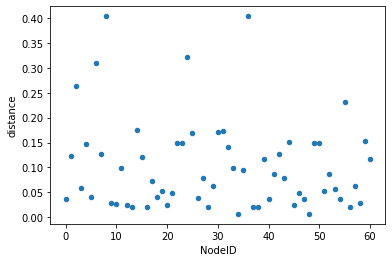

In [61]:
knn.plot.scatter(x='NodeID', y='distance')

<AxesSubplot:xlabel='distance', ylabel='LinkedIn'>

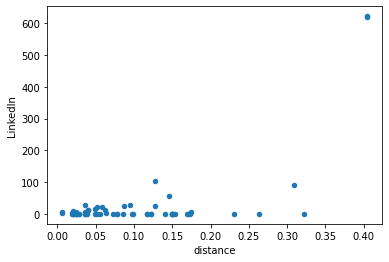

In [62]:
knn.plot.scatter(x='distance', y='LinkedIn')

In [63]:
knn_small_range = knn.copy()
knn_small_range = pd.merge(knn_small_range, df_sims_sorted_large, on=['index','LinkedIn'])
knn_small_range['range'] = knn_small_range['distance'].apply(lambda s: round(s, 1))
knn_small_group = knn_small_range.groupby('range')['range'].count()

knn_small_group

range
0.0    23
0.1    26
0.2     7
0.3     3
0.4     2
Name: range, dtype: int64

In [64]:
knn_small_result = knn_small_range[knn_small_range['range']<0.2]
df_knn_small = knn_small_result.copy()
df_knn_small.shape

(49, 21)

In [65]:

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split 



S1 = pd.DataFrame(list(df_knn_small['CountNorm']))

S2 = pd.DataFrame(list(df_knn_small['SentimentTitle']))

S3 = pd.DataFrame(list(df_knn_small['SentimentHeadline']))

S4 = df_knn_small['Facebook']


X= np.append(S1,S2,axis=1)
X = np.append(X,S3,axis=1)
y = S4.values

knn = KNeighborsClassifier(n_neighbors=2) 


knn.fit(X, y) 

S1 = pd.DataFrame(list(df_test['CountNorm']))
S2 = pd.DataFrame(list(df_test['SentimentTitle']))
S3 = pd.DataFrame(list(df_test['SentimentHeadline']))
S4 = df_test['Facebook']


X_test= np.append(S1,S2,axis=1)
X_test = np.append(X_test,S3,axis=1)
y_test = S4

# Calculate the accuracy of the model 
#print(knn.score(X_train, y_train)) 

print("Predicted as :", knn.predict(X_test)[0], ", Actual Score :", y_test.values[0]) 

Predicted as : 5 , Actual Score : 6


In [66]:
print(knn.kneighbors(X_test))

(array([[0.06206687, 0.11249376]]), array([[11, 31]]))


In [67]:
knn_visual_linkedin = df_knn_small[20:21]
knn_visual_linkedin = knn_visual_linkedin.append(df_knn_small[5:6])

# Comparison of the content

# 1. Title: the given news and its neighbors have similar titles, which are about Microsoft, XBox, price, sales, gift ...

In [68]:
print(df_topic['Title'].values[0])

Xbox One Backward Compatibility: Two new games go live following ...


In [69]:
for index, row in knn_visual_facebook.iterrows():
    print(row['Title'])

Hands-on with Microsoft Garage's new Plumbago app (video)
December Patch Tuesday avalanche of patches includes leaked Xbox certificate


In [70]:
for index, row in knn_visual_google.iterrows():
    print(row['Title'])

PC Market Sluggishness Hit One of Its Lows in 2015
Office 2013 patch KB 3114717 freezes 32-bit Word 2013 on Win 7 ...


In [71]:
for index, row in knn_visual_linkedin.iterrows():
    print(row['Title'])

Xbox One Price Cut To $299,Will The Discount Become Permanent?
Inside The New Microsoft, Where Lie Detection Is A Killer App


# 2. HeadLine: the given news and its neighbors have similar contents, which are about Microsoft, XBox, sales, price, gift ...

In [72]:
print(df_topic['Headline'].values[0])

They weren't the only classic announced by Microsoft, Double Dragon Neon &amp; Ghostbusters: Sanctum of Slime also made the list, completing a


In [73]:
for index, row in knn_visual_facebook.iterrows():
    print(row['Headline'])

Microsoft Garage, much to the chagrin of many Windows users, has previously insisted on releasing its most interesting range of experimental
Microsoft drops 12 security updates, reveals Xbox Live network certificate &quot;inadvertently disclosed&quot;. 


In [74]:
for index, row in knn_visual_google.iterrows():
    print(row['Headline'])

2015 was an important year in Microsoft’s history, with the launch of Windows 10 expected to lift the sluggish PC market. 
 the patch (as best I can tell) hasn't been pulled; and there's been no further announcement on the Technet or Microsoft Answers forums.


In [75]:
for index, row in knn_visual_linkedin.iterrows():
    print(row['Headline'])

 Microsoft revealed an Xbox One price cut Friday as part of a limited time spring sale from March 20 to March 28. The $299 price, down from $349, is not permanent, but it could hint at the future for Xbox One. The new price affects all bundles, which is a great deal considering it covers games such as &quot;Tom Clancy's The Division,&quot; &quot;Gears of War: Ultimate Edition&quot; and the upcoming &quot;Quantum Break.&quot; 
A woman rides a bicycle past a Microsoft sign on the company's main campus in Redmond, Washington in 2014. (Photo by: Mike Kane


# Conclusion
# The data model is that, because the original data are not very related to popularity by checking information gain, we define the preprocessing in the following
# 1. we use Latent Semantic Analysis (LSA) define context to the given news,
# 2. apply KNN to the entire data to get rid of outliers which is far away from the majority of the data set
# 3. after sample selection, we choose Source, SentimentTitle and SentimentHeadline as features to predict popularity.

# 1. According to the content of title and headline, all the news are similar to the given news.
# 2. After preprocessing, ker performance indicators are highly related to targets.
# 3. According to prediction results: 8.2, 3, 0, which are close to actual number of views, 9, 2, 1.
# so that the result set has the answers we are looking for and 
# the data model for popularity prediction is defined right.
